# カタカナの画像認識モデル
手書きカタカナ「アイウエオカキクケコサシスセソ」の15文字を高い精度で識別できるモデルを構築する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

## データ準備

### 訓練データ&検証データの読み込み

In [2]:
train = np.load("../1_data/processed_data_train.npy")
valid = np.load("../1_data/processed_data_valid.npy")
y_train = np.load("../1_data/processed_label_train.npy")
y_valid = np.load("../1_data/processed_label_valid.npy")

In [3]:
print(f'学習用データの形状：{train.shape}')
print(f'学習用ラベルの形状：{y_train.shape}')
print(f'検証用データの形状：{valid.shape}')
print(f'検証用ラベルの形状：{y_valid.shape}')

学習用データの形状：(2100, 1, 28, 28)
学習用ラベルの形状：(2100, 15)
検証用データの形状：(900, 1, 28, 28)
検証用ラベルの形状：(900, 15)


CNNの場合はデータは画像形式(N, C, H, W)  
全結合NNの場合はデータは通常形式(N, H*W)

## モデル構築・学習

ここではCNNで学習を進める  
まずSimpleConvNetとし、その後、層を増やしていく

### NNインスタンスの生成〜ミニバッチ学習〜誤差・精度の記録

In [4]:
# from common.layers import SimpleConvNet

# epochs = 100
# batch_size = 100

# filter_num = 30
# filter_size = 5
# weight_init_std = 0.01

# cnn = SimpleConvNet(input_dim=(1, 28, 28), 
#                      conv_param={'filter_num':filter_num, 'filter_size':filter_size, 'pad':0, 'stride':1},
#                      pool_param={'pool_size':2, 'pad':0, 'stride':2},
#                      hidden_size=100, output_size=15, weight_init_std=weight_init_std, batch_size=batch_size)



- 1. NNインスタンスの作成
- 2. 誤差・精度の記録用リストの生成
- 3. ミニバッチ学習時のoptimizerの生成
- 4. ミニバッチ学習時のバッチサイズと繰り返し計算回数の設定
- 5. エポック（＝全ミニバッチを一巡することを1エポックと数える）
- 6. シャッフル（各エポックにおけるミニバッチ生成用のマスクリストの作成）

なお、関数においては引数は"_input"、出力は"output_"とする

In [19]:
from common.layers import SimpleConvNet
from common.optimizer import RMSProp, NesterovAG
def model_train(_train, _valid, _y_train, _y_valid, 
                _epochs, _batch_size, _filter_num, 
                _filter_size, _weight_init_std):
    # 1. NNインスタンスの作成(CNNのオブジェクト生成)
    cnn_ = SimpleConvNet(input_dim=(1, 28, 28), 
                         conv_param={'filter_num':_filter_num, 'filter_size':_filter_size, 'pad':0, 'stride':1},
                         pool_param={'pool_size':2, 'pad':0, 'stride':2},
                         hidden_size=100, output_size=15, weight_init_std=_weight_init_std, batch_size=_batch_size)

    # 2. 誤差・精度の記録(1) 保存用リストの生成
    train_loss_ = []; valid_loss_ = []; train_acc_ = []; valid_acc_ = []

    # 3. ミニバッチ学習(1) optimizerの生成
    optimizer = RMSProp(lr=0.01, rho=0.9)
    # optimizer = NesterovAG(lr=0.01, momentum=0.9)
    
    # 3. ミニバッチ学習(2) バッチサイズと繰り返し計算回数の設定
    xsize = _train.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(int)
    
    random_seed = 1234

    # 3. ミニバッチ学習(3) エポック（＝全ミニバッチを一巡することを1エポックと数える）の設定
    for epoch in range(epochs):

        # 3. ミニバッチ学習(4) シャッフル（各エポックにおけるミニバッチ生成用のマスクリストの作成）
        idx = np.arange(xsize)
        random_seed += epoch; np.random.seed(seed=random_seed)#seedを固定する
        np.random.shuffle(idx)

        if np.mod(epoch,5)==0: print(f'epoch数：{epoch}, バッチサイズ：{xsize}, seed：{_seed}')#("epoch=%s"%epoch, xsize)
        
        # 3. ミニバッチ学習(5) ランダムなミニバッチを順番に取り出す
        for it in range(iter_num):
            # print("it=", it)
            mask = idx[batch_size*it : batch_size*(it+1)]
            # ミニバッチの生成
            x_train = _train[mask]; t_train = _y_train[mask]
            # 勾配の計算 (誤差逆伝播法を用いる)
            grads = cnn_.gradient(x_train, t_train)
            # 更新
            optimizer.update(cnn_.params, grads)

        # 2. 誤差・精度の記録(2) 学習経過の記録
        _acc_train = cnn_.accuracy(_train, _y_train, batch_size)
        _acc_valid = cnn_.accuracy(_valid, _y_valid, batch_size)
        _loss_train = cnn_.loss(_train, _y_train)
        _loss_valid = cnn_.loss(_valid, _y_valid)
        ## 訓練データおよび検証データにおけるloss
        train_loss_.append(_loss_train); valid_loss_.append(_loss_valid)
        ## 訓練データおよび検証データにて精度を確認
        train_acc_.append(_acc_train); valid_acc_.append(_acc_valid)
        ## 学習経過の標準出力
        print(f'train精度：{_acc_train:.3}, valid精度：{_acc_valid:.3}')
    return cnn_, train_acc_, valid_acc_, train_loss_, valid_loss_

以下で学習関数(model_train)を使って学習を実行する
- 1. MLFlowの設定ファイル読み込み
- 2. model_train(学習用関数)のパラメータ設定
- 3. mlflowの開始（管理IDの発行） 
- 4. model_train(学習用関数)の実行

In [20]:
# 1. MLFlowの設定ファイル読み込み
import configparser
import mlflow
cfg = configparser.ConfigParser()
cfg.read('./config.ini', encoding='utf-8')

# mlflowの初期化
mlflow.end_run()

# Artifactストレージの場所を指定
ARTIFACT_LOCATION = cfg['Path']['artifact_location']

# Experimentの生成
EXPERIMENT_NAME = 'cnn_tuning'
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
                            name=EXPERIMENT_NAME,
                            artifact_location=ARTIFACT_LOCATION)
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id

In [25]:
# 2. model_train(学習用関数)のパラメータ設定
epochs = 100
batch_size = 100
filter_num = 30
filter_size = 5
weight_init_std = 0.01

In [26]:
# 3. mlflowの開始（管理IDの発行） 
with mlflow.start_run(experiment_id=experiment_id):
    trial = 0
    print("mlflow時点のbatch_size", batch_size)

    # 4. model_train(学習用関数)の実行
    tnet, train_acc, valid_acc, train_loss, valid_loss = model_train(train, valid, y_train, y_valid, 
                                                                   epochs, batch_size, filter_num, 
                                                                   filter_size, weight_init_std)

    # 小数点以下３桁まで出力
    print(f'trial {trial}: batch_size={batch_size}, filter_num={filter_num},　train_accuracy={train_acc[-1]:.3}, valid_accuracy={valid_acc[-1]:.3}')

    # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
    mlflow.log_param("filter_num", filter_num)
    mlflow.log_param("filter_size", filter_size)
    mlflow.log_param("weight_init_std", weight_init_std)
    mlflow.log_metric("train_accuracy", train_acc[-1])
    mlflow.log_metric("valid_accuracy", valid_acc[-1])
    mlflow.log_param("random_seed", random_seed)

# mlflowを終了
mlflow.end_run()

mlflow時点のbatch_size 100
class初期化時の値 30 5 0 28 100 0.01
layers.RMSPropのrho 0.9
epoch数：0, バッチサイズ：2100, seed：1234
train精度：0.0829, valid精度：0.0811
epoch数：1, バッチサイズ：2100, seed：1235
train精度：0.664, valid精度：0.644
epoch数：2, バッチサイズ：2100, seed：1237
train精度：0.788, valid精度：0.753
epoch数：3, バッチサイズ：2100, seed：1240
train精度：0.869, valid精度：0.83
epoch数：4, バッチサイズ：2100, seed：1244
train精度：0.876, valid精度：0.83
epoch数：5, バッチサイズ：2100, seed：1249
train精度：0.945, valid精度：0.892
epoch数：6, バッチサイズ：2100, seed：1255
train精度：0.968, valid精度：0.899
epoch数：7, バッチサイズ：2100, seed：1262
train精度：0.975, valid精度：0.907
epoch数：8, バッチサイズ：2100, seed：1270
train精度：0.989, valid精度：0.916
epoch数：9, バッチサイズ：2100, seed：1279
train精度：0.969, valid精度：0.882
epoch数：10, バッチサイズ：2100, seed：1289
train精度：0.988, valid精度：0.908
epoch数：11, バッチサイズ：2100, seed：1300
train精度：0.993, valid精度：0.93
epoch数：12, バッチサイズ：2100, seed：1312
train精度：0.996, valid精度：0.917
epoch数：13, バッチサイズ：2100, seed：1325
train精度：0.999, valid精度：0.928
epoch数：14, バッチサイズ：2100, seed：1339
train精度：0.992, va

### 誤差・精度の確認

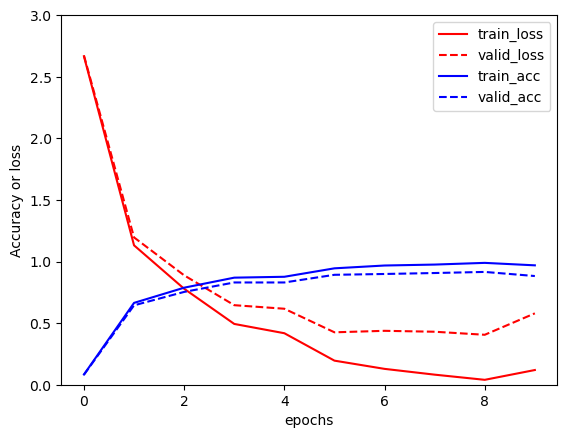

In [24]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "valid_loss":valid_loss,
             "train_acc":train_acc,
             "valid_acc":valid_acc})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

### 学習済みモデルの出力

In [ ]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)